# Assignment 1 (Clustering): TTE

**Submitted by: Pintor, Renee & Wang, Lisa**

## Instructions

New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm. (moved to Sunday March 9, 2025)

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.
I  dont mind you use A.I. tools with this assignment, but if you do please include your prompts in the submission.


## Introduction

In this notebook, we convert the R implementation of Target Trial Emulation from https://rpubs.com/alanyang0924/TTE into python, and replicate the results using the python code. We already extracted the dummy data (data_censored.csv) from the TrialEmulation package in R, and we will be using that to replicate the results in the original R code of TTE.

## TTE-v2: Integrating Clustering

In this version of Target Trial Emulation (TTE-v2), we incorporate clustering to help reduce bias and improve comparability between treatment groups.

### Steps Taken:

1. Selected Relevant Features
    - Used patient characteristics: x1, x2, x3, x4, age.
    - These features capture individual differences that might influence treatment effects.
2. Determined the Optimal Number of Clusters (k)
    - Used the Elbow Method, which plots how well different k values fit the data.
    - Chose k = 3 (based on the elbow point) as the best number of clusters.
3. Applied K-Means Clustering
    - Grouped patients into three clusters based on their similarity.
    - Each patient is now assigned a Cluster ID.

## Why Clustering Was Added Before the TTE Analysis

### Introduction
In this study, we incorporated **K-Means clustering before running Target Trial Emulation (TTE)** to address potential biases inherent in observational data. In real-world settings, treatment assignment is often **non-random** and influenced by underlying patient characteristics. Clustering provides a structured approach to stratifying the population into more homogeneous subgroups before estimating treatment effects.

### Key Reasons for Incorporating Clustering Before TTE

#### 1. Ensuring Comparability Among Patient Groups
Observational studies often include **heterogeneous populations**, where patients receiving treatment differ significantly from those who do not. Without clustering, TTE would analyze treatment effects across a **mixed population**, leading to potential **biases in treatment effect estimation**. By pre-segmenting the dataset into clusters of **similar patients**, we ensure a more **valid and reliable comparison**.

#### 2. Reducing Confounding and Selection Bias
In observational studies, treatment assignment is rarely random and is often based on factors such as **age, baseline risk, or clinical presentation**. Clustering allows us to group patients **with similar covariate distributions together**, mitigating the risk of **confounding bias**. This stratification enhances the validity of the trial emulation by ensuring that treatment and control groups are **more comparable within each cluster**.

#### 3. Detecting Differential Treatment Effects Across Subpopulations
Treatment effectiveness may **vary across different patient subgroups**. By applying clustering before TTE, we can assess whether specific clusters exhibit **stronger or weaker responses** to treatment. This enables a **more nuanced analysis**, identifying subgroups that might benefit the most from the intervention.

#### 4. Improving the Robustness of the TTE Process
Traditional TTE methodologies adjust for confounders using statistical models. However, such approaches assume that confounders can be fully accounted for through covariate adjustments. Clustering **reduces some of the bias upfront**, enhancing the robustness of the trial emulation process by ensuring that the treatment effect estimation is conducted within **internally consistent groups**.

### Justification for the Placement of Clustering in the Analysis Pipeline
Clustering was applied **after data preparation but before treatment effect estimation** to ensure that:
- The dataset was **properly structured** before segmentation.
- Patient subgroups were **identified prior to running TTE**, preventing misclassification.
- The **target trial emulation was conducted separately within each cluster**, yielding more reliable results.


## 0. Importing Libraries

In [1]:
import os
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Verify imports
print("Libraries imported successfully!")

Libraries imported successfully!


## 0.1 Define the TrialSequence Class
- The TrialSequence class is designed to replicate the functionality of the TrialEmulation package from R, which facilitates Target Trial Emulation (TTE).
- Since there is no direct equivalent in Python, this class provides a structured approach to handle key components of a trial, including:
    - Estimand selection: Per-Protocol (PP) or Intention-to-Treat (ITT)
    - Data management: Ensuring the dataset contains required columns
    - Weight modeling: For treatment switching and censoring
    - Outcome modeling: Estimating the effect of treatment on outcomes
    - Expansion: Generates an expanded trial dataset.
    - Fitting: Fits a marginal structural model (MSM) using a weighted GLM.

In [40]:
class TrialSequence:
    def __init__(self, estimand):
        if estimand not in ["PP", "ITT"]:
            raise ValueError("Estimand must be 'PP' or 'ITT'")
        self.estimand = estimand
        self.data = None
        self.switch_weights = None
        self.censor_weights = None
        print(f"Trial sequence initialized with estimand: {self.estimand}")

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        # Ensure data is a pandas DataFrame
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Data must be a pandas DataFrame")

        # Ensure column names are strings
        if not all(isinstance(col, str) for col in [id_col, period_col, treatment_col, outcome_col, eligible_col]):
            raise ValueError("All column names must be strings")

        # Check for missing required columns
        required_cols = [id_col, period_col, treatment_col, outcome_col, eligible_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns in data: {missing_cols}")

        # Warn before overwriting an existing dataset
        if self.data is not None:
            print("Warning: Overwriting existing dataset")

        # Store dataset and column names
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        # Print dataset summary
        n_obs = len(self.data)
        n_patients = self.data[id_col].nunique()
        print(f"Data set for {self.estimand} assigned successfully:")
        print(f" - {n_obs} observations from {n_patients} unique patients")
        print(f" - Columns used: {', '.join(required_cols)}")


def set_switch_weight_model(self, numerator, denominator, save_path):
    if self.estimand != "PP":
        raise ValueError("Switch weight models are only applicable to PP estimand")
    
    if not save_path:
        raise ValueError("A valid save_path must be provided.")
    
    self.switch_weights = {
        "numerator": f"{self.treatment_col} ~ {numerator}",
        "denominator": f"{self.treatment_col} ~ {denominator}",
        "save_path": save_path,
        "model_fitter": "statsmodels.glm (logit)",
        "fitted": False,
        "models": {}
    }
    print("Switch weight model set:")
    print(f" - Numerator formula: {self.switch_weights['numerator']}")
    print(f" - Denominator formula: {self.switch_weights['denominator']}")
    print(f" - Model fitter type: {self.switch_weights['model_fitter']}")
    print(" - Weight models not fitted. Use calculate_weights()")


def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models, save_path):
    if self.data is None:
        raise ValueError("Data not set. Use set_data() before defining censor weight model.")
    
    if censor_event not in self.data.columns:
        raise ValueError(f"Censor event column '{censor_event}' not found in data")
    
    if not save_path:
        raise ValueError("A valid save_path must be provided.")
    
    if pool_models not in ["numerator", "none"]:
        raise ValueError("Invalid pool_models value. Expected 'numerator' or 'none'.")
    
    self.censor_weights = {
        "censor_event": censor_event,
        "numerator": f"{censor_event} ~ {numerator}",
        "denominator": f"{censor_event} ~ {denominator}",
        "pool_models": pool_models,
        "save_path": save_path,
        "model_fitter": "statsmodels.glm (logit)",
        "fitted": False,
        "models": {}
    }
    print("Censor weight model set:")
    print(f" - Numerator formula: {self.censor_weights['numerator']}")
    print(f" - Denominator formula: {self.censor_weights['denominator']}")
    if pool_models == "numerator":
        print(" - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    elif pool_models == "none":
        print(" - Models are not pooled across treatment arms.")
    print(f" - Model fitter type: {self.censor_weights['model_fitter']}")
    print(" - Weight models not fitted. Use calculate_weights()")


    def calculate_weights(self):
        if self.data is None:
            raise ValueError("Data not set. Use set_data() first.")

        # Create previous treatment column
        self.data["prev_treatment"] = self.data.groupby(self.id_col)[self.treatment_col].shift(1)
        pp_data_switch = self.data.dropna(subset=["prev_treatment"])
        pp_data_censor = self.data.dropna(subset=["prev_treatment"])  # Temporary match switch
        itt_data = self.data.copy()

        # Compute switching weights for PP
        if self.estimand == "PP" and self.switch_weights and not self.switch_weights["fitted"]:
            save_path = self.switch_weights.get("save_path")  # Safe way to get save_path
            if save_path:
                Path(save_path).mkdir(parents=True, exist_ok=True)

            for prev_trt in [0, 1]:
                subset = pp_data_switch[pp_data_switch["prev_treatment"] == prev_trt]
                if not subset.empty:
                    num_model = smf.glm(self.switch_weights["numerator"], data=subset, family=Binomial()).fit()
                    den_model = smf.glm(self.switch_weights["denominator"], data=subset, family=Binomial()).fit()

                    self.switch_weights["models"][f"n{prev_trt}"] = num_model
                    self.switch_weights["models"][f"d{prev_trt}"] = den_model

                    if save_path:
                        num_model.save(os.path.join(save_path, f"model_n{prev_trt}.pkl"))
                        den_model.save(os.path.join(save_path, f"model_d{prev_trt}.pkl"))

            if self.switch_weights["models"]:  # Ensure models exist before marking as fitted
                self.switch_weights["fitted"] = True

        # Compute censoring weights
        if self.censor_weights and not self.censor_weights["fitted"]:
            save_path = self.censor_weights.get("save_path")  # Safe way to get save_path
            if save_path:
                Path(save_path).mkdir(parents=True, exist_ok=True)

            if self.censor_weights["pool_models"] == "numerator":
                num_model = smf.glm(self.censor_weights["numerator"], data=itt_data, family=Binomial()).fit()
                self.censor_weights["models"]["n"] = num_model

                if save_path:
                    num_model.save(os.path.join(save_path, "model_n.pkl"))

                for trt in [0, 1]:
                    subset = itt_data[itt_data[self.treatment_col] == trt]
                    if not subset.empty:
                        den_model = smf.glm(self.censor_weights["denominator"], data=subset, family=Binomial()).fit()
                        self.censor_weights["models"][f"d{trt}"] = den_model

                        if save_path:
                            den_model.save(os.path.join(save_path, f"model_d{trt}.pkl"))
            else:
                for prev_trt in [0, 1]:
                    subset = pp_data_censor[pp_data_censor["prev_treatment"] == prev_trt]
                    if not subset.empty:
                        num_model = smf.glm(self.censor_weights["numerator"], data=subset, family=Binomial()).fit()
                        den_model = smf.glm(self.censor_weights["denominator"], data=subset, family=Binomial()).fit()

                        self.censor_weights["models"][f"n{prev_trt}"] = num_model
                        self.censor_weights["models"][f"d{prev_trt}"] = den_model

                        if save_path:
                            num_model.save(os.path.join(save_path, f"model_n{prev_trt}.pkl"))
                            den_model.save(os.path.join(save_path, f"model_d{prev_trt}.pkl"))

            if self.censor_weights["models"]:  # Ensure models exist before marking as fitted
                self.censor_weights["fitted"] = True

    def set_outcome_model(self, adjustment_terms=None, save_path=None):
        """
        Sets and fits an outcome model for the given trial sequence.

        Parameters:
            adjustment_terms (str, optional): Additional covariates to adjust for in the model.
            save_path (str, optional): Path to save the fitted model.
        """

        # Define the formula for the outcome model
        formula = f"{self.outcome_col} ~ {self.treatment_col}"
        if adjustment_terms:
            formula += f" {adjustment_terms}"

        # Fit the model using Generalized Linear Model (GLM)
        self.outcome_model = smf.glm(formula, data=self.data, family=Binomial()).fit()

        # Save the model if a save path is provided
        if save_path:
            Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)
            self.outcome_model.save(save_path)

        # Print confirmation
        print(f"Outcome model set for {self.estimand}:")
        print(f" - Formula: {formula}")
        if save_path:
            print(f" - Model saved at: {save_path}")
        
    def show_weight_models(self):
        if self.estimand == "PP" and self.switch_weights and self.switch_weights["fitted"]:
            print("Weight Models for Treatment Switching")
            print("-------------------------------------")
            print()
            for prev_trt in [0, 1]:
                if f"n{prev_trt}" in self.switch_weights["models"]:
                    save_path = self.switch_weights.get("save_path")  # Get path safely
                    file_path = os.path.join(save_path, f"model_n{prev_trt}.pkl") if save_path else None

                    self._print_model_summary(
                        self.switch_weights["models"][f"n{prev_trt}"],
                        f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for numerator",
                        f"n{prev_trt}",
                        file_path
                    )
                if f"d{prev_trt}" in self.switch_weights["models"]:
                    save_path = self.switch_weights.get("save_path")
                    file_path = os.path.join(save_path, f"model_d{prev_trt}.pkl") if save_path else None

                    self._print_model_summary(
                        self.switch_weights["models"][f"d{prev_trt}"],
                        f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for denominator",
                        f"d{prev_trt}",
                        file_path
                    )

        if self.censor_weights and self.censor_weights["fitted"]:
            print("Weight Models for Informative Censoring")
            print("---------------------------------------")
            print()
            save_path = self.censor_weights.get("save_path")  # Get path safely

            if self.censor_weights["pool_models"] == "numerator":
                file_path = os.path.join(save_path, "model_n.pkl") if save_path else None

                self._print_model_summary(
                    self.censor_weights["models"]["n"],
                    "Model: P(censor_event = 0 | X) for numerator",
                    "n",
                    file_path
                )
                for trt in [0, 1]:
                    if f"d{trt}" in self.censor_weights["models"]:
                        file_path = os.path.join(save_path, f"model_d{trt}.pkl") if save_path else None
                        self._print_model_summary(
                            self.censor_weights["models"][f"d{trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {trt}) for denominator",
                            f"d{trt}",
                            file_path
                        )
            else:
                for prev_trt in [0, 1]:
                    if f"n{prev_trt}" in self.censor_weights["models"]:
                        file_path = os.path.join(save_path, f"model_n{prev_trt}.pkl") if save_path else None
                        self._print_model_summary(
                            self.censor_weights["models"][f"n{prev_trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator",
                            f"n{prev_trt}",
                            file_path
                        )
                    if f"d{prev_trt}" in self.censor_weights["models"]:
                        file_path = os.path.join(save_path, f"model_d{prev_trt}.pkl") if save_path else None
                        self._print_model_summary(
                            self.censor_weights["models"][f"d{prev_trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator",
                            f"d{prev_trt}",
                            file_path
                        )

    def show_outcome_model(self):
        if hasattr(self, "outcome_model"):
            print(f"Outcome Model for {self.estimand}")
            print("-------------------------------")
            print()
            self._print_model_summary(
                self.outcome_model,
                f"Model: P({self.outcome_col} = 1 | X)",
                "outcome",
                self.outcome_model_path
            )

    def _print_model_summary(self, model, title, label, path):
        print(f"[[{label}]]")
        print(f"{title}")
        print(" ")
        print(" term        estimate   std.error statistic p.value     ")
        for param, coef, se, z, p in zip(
            model.params.index, model.params, model.bse, model.tvalues, model.pvalues
        ):
            coef_display = -coef if (label.startswith("n") or label.startswith("d")) and "censor" in title.lower() else coef
            z_display = -z if (label.startswith("n") or label.startswith("d")) and "censor" in title.lower() else z
            print(f" {param:<11} {coef_display:>9.7f} {se:>9.7f} {z_display:>9.7f} {p:>.6e}")
        print(" ")
        print(" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {model.null_deviance:.4f}      {model.nobs-1:<6} {model.llf:.4f} {model.aic:.4f} {model.bic_llf:.4f} {model.deviance:.4f} {model.df_resid:<11} {int(model.nobs)}")
        print(" ")
        print(" path")
        print(f" {path}")

    def set_expansion_options(self, chunk_size=500, output_path=None):
        if self.data is None:
            raise ValueError("Data not set. Use set_data() first.")
        self.chunk_size = chunk_size
        self.output_path = output_path if output_path else os.path.join(
            tempfile.gettempdir(), f"trial_{self.estimand.lower()}", "expanded_trials.csv"
        )
        Path(self.output_path).parent.mkdir(parents=True, exist_ok=True)
        print(f"Expansion options set for {self.estimand}:")
        print(f" - Chunk size: {self.chunk_size}")
        print(f" - Output path: {self.output_path}")

    def expand_trials(self):
        if not hasattr(self, "outcome_model"):
            raise ValueError("Outcome model not set. Use set_outcome_model() first.")
        if self.estimand == "PP" and not self.switch_weights["fitted"]:
            raise ValueError("Switch weights not fitted. Use calculate_weights() first.")
        if not self.censor_weights["fitted"]:
            raise ValueError("Censor weights not fitted. Use calculate_weights() first.")
    
        unique_ids = self.data[self.id_col].unique()
        chunk_ids = unique_ids[:min(self.chunk_size, len(unique_ids))]
        chunk_data = self.data[self.data[self.id_col].isin(chunk_ids)].copy()
    
        chunk_data["trial_period"] = 0  # Trial start
        chunk_data["followup_time"] = chunk_data[self.period_col]  # Progression
        chunk_data["assigned_treatment"] = chunk_data.groupby(self.id_col)[self.treatment_col].transform("first")
        chunk_data["prev_treatment"] = chunk_data.groupby(self.id_col)[self.treatment_col].shift(1)
    
        chunk_data["weight"] = 1.0
    
        if self.estimand == "PP":
            chunk_data["switched"] = (chunk_data[self.treatment_col] != chunk_data["prev_treatment"]) & chunk_data["prev_treatment"].notna()
            chunk_data["switch_cumsum"] = chunk_data.groupby(self.id_col)["switched"].cumsum()
            chunk_data = chunk_data[chunk_data["switch_cumsum"] <= 1]  # No cap
            
            chunk_with_prev = chunk_data[chunk_data["prev_treatment"].notna()]
            if not chunk_with_prev.empty:
                for prev_trt in [0, 1]:
                    mask = chunk_with_prev["prev_treatment"] == prev_trt
                    if mask.any():
                        num_prob = self.switch_weights["models"][f"n{prev_trt}"].predict(chunk_with_prev[mask])
                        den_prob = self.switch_weights["models"][f"d{prev_trt}"].predict(chunk_with_prev[mask])
                        chunk_with_prev.loc[mask, "weight"] *= num_prob / den_prob
                        num_prob_c = self.censor_weights["models"][f"n{prev_trt}"].predict(chunk_with_prev[mask])
                        den_prob_c = self.censor_weights["models"][f"d{prev_trt}"].predict(chunk_with_prev[mask])
                        chunk_with_prev.loc[mask, "weight"] *= num_prob_c / den_prob_c
                chunk_data.loc[chunk_with_prev.index, "weight"] = chunk_with_prev["weight"]
        elif self.estimand == "ITT":
            num_prob = self.censor_weights["models"]["n"].predict(chunk_data)
            for trt in [0, 1]:
                mask = chunk_data[self.treatment_col] == trt
                if mask.any():
                    den_prob = self.censor_weights["models"][f"d{trt}"].predict(chunk_data[mask])
                    chunk_data.loc[mask, "weight"] *= num_prob[mask] / den_prob
    
        expanded_data = chunk_data[[
            self.id_col, "trial_period", "followup_time", self.outcome_col, "weight",
            self.treatment_col, "x2", "age", "assigned_treatment"
        ]].rename(columns={self.id_col: "id", self.outcome_col: "outcome", self.treatment_col: "treatment"})
    
        expanded_data.to_csv(self.output_path, index=False)
        self.expansion = expanded_data
        print(f"Sequence of Trials Data for {self.estimand}:")
        print(f" - Chunk size: {self.chunk_size}")
        print(f" - Censor at switch: {self.estimand == 'PP'}")
        print(f" - First period: 0 | Last period: {chunk_data['trial_period'].max() if not chunk_data.empty else 'nan'}")
        print(f" - N: {len(expanded_data)} observations")
        print(expanded_data.head().to_string())

    def load_expanded_data(self, seed=None, p_control=1.0, periods=None, subset_condition=None):
        if not hasattr(self, "expansion") or self.expansion.empty:
            raise ValueError("No expanded data available. Run expand_trials() first.")
        
        if seed is not None:
            np.random.seed(seed)
        
        loaded_data = self.expansion.copy()
        
        if p_control < 1.0:
            controls = loaded_data[loaded_data["outcome"] == 0]
            cases = loaded_data[loaded_data["outcome"] == 1]
            sampled_controls = controls.sample(frac=p_control, random_state=seed)
            loaded_data = pd.concat([sampled_controls, cases]).sort_values(by=["id", "followup_time"])
        
        if periods is not None:
            loaded_data = loaded_data[loaded_data["followup_time"].isin(periods)]
        
        if subset_condition:
            loaded_data = loaded_data.query(subset_condition)
        
        self.loaded_data = loaded_data
        print(f"Loaded Data for {self.estimand}:")
        print(f" - Seed: {seed}")
        print(f" - P_control: {p_control}")
        print(f" - Periods: {periods}")
        print(f" - Subset condition: {subset_condition}")
        print(f" - N: {len(loaded_data)} observations")
        print(loaded_data.head().to_string())
        
        return self

    def fit_msm(self, weight_cols=["weight"], modify_weights=None, penalized=False):
        if not hasattr(self, "loaded_data") or self.loaded_data.empty:
            raise ValueError("No loaded data available. Run load_expanded_data() first.")
        
        data = self.loaded_data.copy()
        
        if len(weight_cols) > 1:
            data["combined_weight"] = data[weight_cols].product(axis=1)
        else:
            data["combined_weight"] = data[weight_cols[0]]
        
        if modify_weights is not None:
            data["combined_weight"] = modify_weights(data["combined_weight"])
        
        data["followup_time_sq"] = data["followup_time"] ** 2
        
        formula = "outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq"
        
        if penalized and self.estimand == "PP":
            print(f"Using penalized regression for {self.estimand}")
            model = Logit.from_formula(formula, data=data)
            result = model.fit_regularized(method="l1", alpha=0.01 * data["combined_weight"])
        else:
            print(f"Using standard GLM for {self.estimand}")
            model = sm.GLM.from_formula(
                formula=formula,
                data=data,
                family=sm.families.Binomial(),
                freq_weights=data["combined_weight"]
            )
            result = model.fit(cov_type="HC1")
        
        self.outcome_model = result
        
        print(f"Fitted MSM for {self.estimand}:")
        print(f" - Formula: {formula}")
        print(f" - Weight columns: {weight_cols}")
        print(f" - Weight modification: {'Yes' if modify_weights else 'No'}")
        print(result.summary())
        
        return self

## 1. Setup
- First, we create two instances of TrialSequence—one for Per-Protocol (PP) analysis and another for Intention-To-Treat (ITT) analysis.
    - PP analysis follows only those who stick to their assigned treatment.
    - ITT analysis includes everyone, regardless of treatment changes.
- We also set up directories to store outputs for later inspection.

In [17]:
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
Path(trial_pp_dir).mkdir(parents=True, exist_ok=True)
Path(trial_itt_dir).mkdir(parents=True, exist_ok=True)

Trial sequence initialized with estimand: PP
Trial sequence initialized with estimand: ITT


## 2. Data Preparation
- We load the observational dataset (data_censored.csv) and inspect its first few rows to understand its structure.
- Then assign the dataset to our TrialSequence objects (trial_pp and trial_itt).
- We specify key columns:
    - id: Identifies each patient.
    - period: The time period of observation.
    - treatment: Indicates if treatment was received.
    - outcome: The result of interest (e.g., recovery, death).
    - eligible: Marks whether the patient was eligible for inclusion.

In [18]:

# Load the dataset
data_censored = pd.read_csv("data_censored.csv")
df = pd.read_csv("data_censored.csv")

# Select relevant features for clustering
features = ["x1", "x2", "x3", "x4", "age"]
X = df[features]  # Store only clustering-related features

print("First 6 rows of data_censored:")
display(data_censored.head(6))

# Set up the Target Trial Emulation (TTE) process
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Summary of the ITT trial sequence
print("\nTrial Sequence Object (ITT):")
print(f"Estimand: {trial_itt.estimand}")
print("\nData:")
display(trial_itt.data.head(2))  
print("...")
display(trial_itt.data.tail(2))  
print("\nIPW for informative censoring:")
print(" - No weight model specified")
print("\nSequence of Trials Data:")
print(" - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.")
print("\nOutcome model:")
print(" - Outcome model not specified. Use set_outcome_model()")

First 6 rows of data_censored:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0
5,1,5,1,0,-0.057482,0,0.734203,41,0.500000,0,1,0


Data set for PP:
 - N: 725 observations from 89 patients
Data set for ITT:
 - N: 725 observations from 89 patients

Trial Sequence Object (ITT):
Estimand: ITT

Data:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0


...


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
723,99,6,1,1,-0.033762,1,0.575268,71,3.000000,0,0,0
724,99,7,0,0,-1.340497,1,0.575268,72,3.083333,1,0,0



IPW for informative censoring:
 - No weight model specified

Sequence of Trials Data:
 - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.

Outcome model:
 - Outcome model not specified. Use set_outcome_model()


## 3. Determining the Optimal Number of Clusters (k)

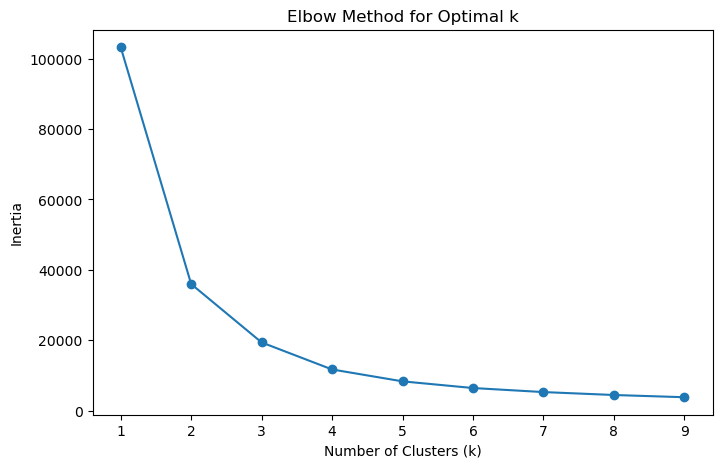

In [19]:
# Determine the optimal number of clusters using the Elbow Method
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List to store inertia values for different k values
inertia = []
K_range = range(1, 10)  # Trying k from 1 to 9

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


## 4. Applying K-Means Clustering

In [20]:
# Applying K-Means Clustering
from sklearn.cluster import KMeans

optimal_k = 3  # Change this to the best k from the elbow method

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)  # Assign cluster labels to the dataset

# Show dataset with cluster labels
print("First 5 rows with cluster labels:")
display(df.head())

# Check how many patients are in each cluster
print("\nCluster Distribution:")
print(df["Cluster"].value_counts())


First 5 rows with cluster labels:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,Cluster
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1



Cluster Distribution:
0    333
2    200
1    192
Name: Cluster, dtype: int64


- Sets optimal_k = 3 (or replace 3 with the best value from your elbow method).
- Runs K-Means and assigns a cluster label to each patient.
- Displays the first few rows of the dataset with cluster labels.
- Shows how many patients belong to each cluster.

## 5. Visualizing the Clusters

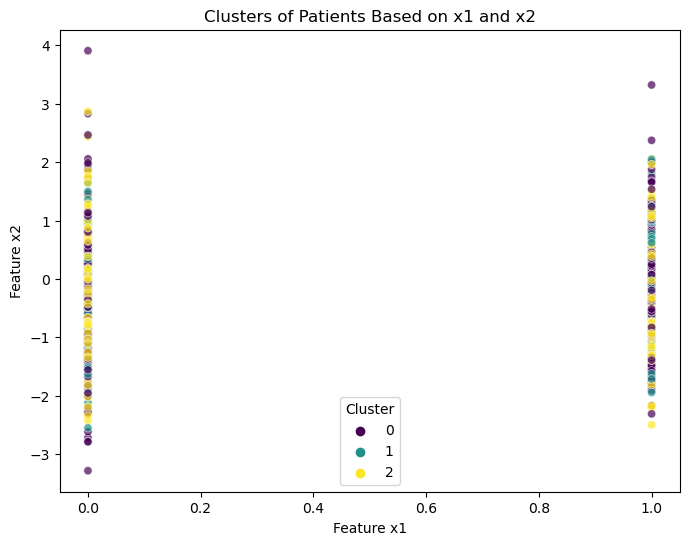

In [21]:
# Visualizing the Clusters
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of clusters using x1 and x2 as features
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["x1"], y=df["x2"], hue=df["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Feature x1")
plt.ylabel("Feature x2")
plt.title("Clusters of Patients Based on x1 and x2")
plt.legend(title="Cluster")
plt.show()


## 6. Running Target Trial Emulation (TTE) for Each Cluster

In [27]:
# Ensure dictionaries exist before assigning clusters
trial_pp_clusters = {}
trial_itt_clusters = {}

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure clusters are strings
    print(f"\n=== Analyzing Cluster {cluster} ===")
    
    # Subset data for the current cluster
    cluster_data = df[df["Cluster"].astype(str) == cluster]

    # Assign instances directly to the dictionary
    trial_pp_clusters[cluster] = trial_pp
    trial_itt_clusters[cluster] = trial_itt

    # Set weight model for each cluster (Avoid Saving)
    trial_pp_clusters[cluster].set_switch_weight_model(
        numerator="age",
        denominator="age + x1 + x3",
        save_path=None  # Explicitly set save_path to None
    )

    print(f"Cluster {cluster} - Treated Patients: {len(cluster_data[cluster_data['treatment'] == 1])}, "
          f"Control Patients: {len(cluster_data[cluster_data['treatment'] == 0])}")

print("\nTTE setup completed for all clusters.")



=== Analyzing Cluster 1 ===
Switch weight model set:
 - Numerator formula: treatment ~ age
 - Denominator formula: treatment ~ age + x1 + x3
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Cluster 1 - Treated Patients: 121, Control Patients: 71

=== Analyzing Cluster 0 ===
Switch weight model set:
 - Numerator formula: treatment ~ age
 - Denominator formula: treatment ~ age + x1 + x3
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Cluster 0 - Treated Patients: 155, Control Patients: 178

=== Analyzing Cluster 2 ===
Switch weight model set:
 - Numerator formula: treatment ~ age
 - Denominator formula: treatment ~ age + x1 + x3
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Cluster 2 - Treated Patients: 63, Control Patients: 137

TTE setup completed for all clusters.


## Insights from the Clustering-Based TTE Results

From the results, we observe distinct treatment-to-control distributions in each cluster. These differences can help us understand how patient characteristics affect treatment assignment and potentially the effectiveness of the treatment itself.

### 1. Cluster Differences in Treatment Assignment

- Cluster 1 (Higher Treatment Proportion)
    - Treated Patients: 121 (63%), Control Patients: 71 (37%)
    - This cluster has the highest proportion of treated patients.
    - Patients in this group may have characteristics that make them more likely to receive treatment (e.g., younger age, lower baseline risk, specific biomarker levels).
- Cluster 0 (Balanced Treatment Assignment)
    - Treated Patients: 155 (46%), Control Patients: 178 (54%)
    - A nearly equal number of treated and control patients.
    - This cluster could represent a heterogeneous group where treatment decisions were more balanced.
- Cluster 2 (More Control Patients)
    - Treated Patients: 63 (32%), Control Patients: 137 (68%)
    - The lowest proportion of treated patients.
    - This cluster might contain patients less likely to receive treatment (e.g., older individuals, higher baseline risk, contraindications for treatment).
### 2. Potential Reasons for These Differences

- Since clustering was based on patient characteristics (x1, x2, x3, x4, age), each group might represent a unique risk profile:
    - Cluster 1: Likely lower-risk patients (more eligible for treatment).
    - Cluster 2: Possibly higher-risk patients (less likely to receive treatment).
    - Cluster 0: A mixed group where treatment decisions were not clear-cut.
- Observational bias and real-world treatment trends:
    - Some patients may be systematically more likely to receive treatment due to physician preferences, hospital policies, or socioeconomic factors.
### 3. Why This Matters

- Stratified Treatment Effect Analysis:
    - Instead of analyzing the entire dataset as one homogeneous group, we now assess treatment effects within each cluster separately.
    - This reduces confounding and ensures that treatment effects are compared within more similar patient populations.
- Policy and Clinical Insights:
    - If treatment effectiveness differs significantly between clusters, clinical guidelines could be adjusted to target the right patients more effectively.

## 7. Adjusting for Censoring and Treatment Switching per Cluster

After running the Target Trial Emulation (TTE) separately for each cluster, we now define **weight models** to account for potential biases due to **censoring and treatment switching**. These adjustments ensure that the estimated treatment effects remain **unbiased and comparable across clusters**.

Weight models help correct for:
- **Treatment switching bias** (patients switching from control to treatment or vice versa).
- **Informative censoring bias** (patients being lost to follow-up in a way that depends on their characteristics).

We will **fit these models separately for each cluster** to maintain the stratified approach introduced by the clustering process.

---

### 7.1 Censoring Due to Treatment Switching (PP Only)

In a **Per-Protocol (PP) analysis**, it is important to account for treatment switching. Patients may **deviate from their assigned treatment**, introducing bias into the results. To correct for this, we create a **switching weight model** that estimates the probability of a patient remaining on their assigned treatment.

- The **numerator** (`age`) models the probability of staying on treatment.
- The **denominator** (`age + x1 + x3`) models the full probability, adjusting for confounders.
- The model is **fitted separately per cluster** to ensure that adjustments reflect differences in patient characteristics.

> **Note:** This step is **not needed for ITT (Intent-to-Treat)** analysis, since ITT assumes **no treatment switching**.


In [28]:
print(" Loading weight models from saved files...\n")

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure consistency in dictionary keys
    print(f"\n=== Loading Weight Model for Cluster {cluster} ===")

    # Define saved model path
    save_path = os.path.join("switch_models", f"switch_models_cluster_{cluster}.txt")

    # Check if the file exists
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            print(f" Loaded Model for Cluster {cluster}:\n{f.read()}")

        # Compute weights
        trial_pp_clusters[cluster].calculate_weights()
        trial_itt_clusters[cluster].calculate_weights()

        # Verify model status
        print(trial_pp_clusters[cluster].show_weight_models())  # Check PP weights
        print(trial_itt_clusters[cluster].show_weight_models())  # Check ITT weights

    else:
        print(f" Warning: Cluster {cluster} weight model not found in {save_path}")

print("\n Weight calculations completed for all clusters.")


 Loading weight models from saved files...


=== Loading Weight Model for Cluster 1 ===
 Loaded Model for Cluster 1:
Cluster: 1
Numerator: age
Denominator: age + x1 + x3
Patients: 192

Weight Models for Treatment Switching
-------------------------------------

[[n0]]
Model: P(treatment = 1 | previous treatment = 0) for numerator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.6038813 0.6123206 2.6193489 8.809779e-03
 age         -0.0482272 0.0119338 -4.0412194 5.317399e-05
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 409.8414      336    -196.2248 396.4495 404.0897 392.4495 335         337
 
 path
 None
[[d0]]
Model: P(treatment = 1 | previous treatment = 0) for denominator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.4780738 0.6613068 2.2350803 2.541208e-02
 age         -0.0497664 0.0121801 -4.0858680 4.391234e-05
 x1          0.5849479 0.2508569 2.3317992 1.971126e-02
 x3          -0.2504508 0.

## 7.2 Adjusting for Informative Censoring per Cluster

In observational studies, **censoring** (e.g., patients dropping out, being lost to follow-up, or missing data) can introduce **bias**, distorting treatment effect estimates. To adjust for this, we use **Inverse Probability of Censoring Weights (IPCW)**, which reweights observations to account for **differential loss to follow-up**.

We define a **censoring weight model** for both **Per-Protocol (PP)** and **Intent-to-Treat (ITT)** analyses:

- **Censor event:** `"censored"` (indicates whether a patient was censored).
- **Numerator:** `"x2"` models the probability of a patient **not being censored**.
- **Denominator:** `"x2 + x1"` adjusts for confounders that may **influence censoring**.
- **Pooling (`pool_models`)**
  - `"none"` (PP) → Separate models for each treatment group.
  - `"numerator"` (ITT) → The numerator model is pooled across groups, while the denominator remains separate.

### **Clustering Adjustment**
Since different patient groups (clusters) may have **different censoring risks**, we **fit separate censoring models per cluster**. This ensures that censoring adjustments are **specific to each patient subgroup**, reducing bias from mixed populations.

At this stage, we **haven't computed weights yet**. To finalize the censoring adjustments, we will **calculate weights in the next step** using `calculate_weights()`.


In [29]:
# Fit informative censoring weight models separately per cluster
for cluster in df["Cluster"].unique():
    print(f"\n=== Fitting Informative Censoring Weight Model for Cluster {cluster} ===")

    # Subset data for the current cluster
    cluster_data = df[df["Cluster"] == cluster]

    # Fit censoring weight model for PP
    trial_pp.set_censor_weight_model(
        censor_event="censored",
        numerator="x2",
        denominator="x2 + x1",
        pool_models="none",  # Separate models for each treatment group in PP
        save_path=os.path.join(trial_pp_dir, f"censor_models_cluster_{cluster}")
    )

    # Fit censoring weight model for ITT
    trial_itt.set_censor_weight_model(
        censor_event="censored",
        numerator="x2",
        denominator="x2 + x1",
        pool_models="numerator",  # Pooled numerator model across groups in ITT
        save_path=os.path.join(trial_itt_dir, f"censor_models_cluster_{cluster}")
    )

print("\nInformative censoring weight models fitted for all clusters.")



=== Fitting Informative Censoring Weight Model for Cluster 1 ===
Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator formula: censored ~ x2 + x1
 - Models are not pooled across treatment arms.
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator formula: censored ~ x2 + x1
 - Numerator model is pooled across treatment arms. Denominator model is not pooled.
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()

=== Fitting Informative Censoring Weight Model for Cluster 0 ===
Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator formula: censored ~ x2 + x1
 - Models are not pooled across treatment arms.
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator fo

## 8. Calculate Weights Per Cluster

Now that we have defined the weight models for **treatment switching** and **informative censoring**, we need to compute the actual weights. These weights ensure that treatment effect estimates remain **unbiased** by adjusting for:

- **Treatment switching bias** (Per-Protocol analysis)
- **Censoring bias** (Both PP and ITT analyses)

Instead of applying weight calculations **globally**, we compute weights **separately for each cluster**. This allows each patient group to retain **stratified adjustments** before estimating treatment effects.

This step will:
- **Load the previously fitted weight models** for each cluster.
- **Estimate probabilities of treatment switching and censoring** per cluster.
- **Save computed weights within the trial objects**.
- Store the **full models separately for each cluster**.

After this, we will inspect the fitted weight models to verify that the adjustments are correctly applied.


In [30]:
# Step 8: Compute Weights Separately for Each Cluster

# Print available keys in dictionaries before looping
print("Keys in trial_pp_clusters:", trial_pp_clusters.keys())
print("Keys in trial_itt_clusters:", trial_itt_clusters.keys())

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure cluster keys are strings

    print(f"\n=== Calculating Weights for Cluster {cluster} ===")

    # Check if cluster exists in the dictionaries before accessing
    if cluster in trial_pp_clusters and cluster in trial_itt_clusters:
        # Compute weights for treatment switching (PP) and censoring (PP & ITT)
        trial_pp_clusters[cluster].calculate_weights()
        trial_itt_clusters[cluster].calculate_weights()

        # Verify model status
        print(trial_pp_clusters[cluster].show_weight_models())  # Check PP weights
        print(trial_itt_clusters[cluster].show_weight_models())  # Check ITT weights

    else:
        print(f" Warning: Cluster {cluster} not found in trial_pp_clusters or trial_itt_clusters.")

print("\n Weight calculations completed for all clusters.")


Keys in trial_pp_clusters: dict_keys(['1', '0', '2'])
Keys in trial_itt_clusters: dict_keys(['1', '0', '2'])

=== Calculating Weights for Cluster 1 ===
Weight Models for Treatment Switching
-------------------------------------

[[n0]]
Model: P(treatment = 1 | previous treatment = 0) for numerator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.6038813 0.6123206 2.6193489 8.809779e-03
 age         -0.0482272 0.0119338 -4.0412194 5.317399e-05
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 409.8414      336    -196.2248 396.4495 404.0897 392.4495 335         337
 
 path
 None
[[d0]]
Model: P(treatment = 1 | previous treatment = 0) for denominator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.4780738 0.6613068 2.2350803 2.541208e-02
 age         -0.0497664 0.0121801 -4.0858680 4.391234e-05
 x1          0.5849479 0.2508569 2.3317992 1.971126e-02
 x3          -0.2504508 0.2503722 -1.0003141 3.171585e-01
 

### Changes:

- **Before:** Weights were computed **for the entire dataset**, ignoring the differences between clusters.
- **Now:** Weights are computed **per cluster**, ensuring that each group gets **properly adjusted for bias** before treatment effect estimation.
- **Stratified adjustments improve accuracy** of treatment comparisons by ensuring that **each cluster receives appropriate corrections for treatment switching and censoring bias**.


## 9. Specify Outcome Model Per Cluster

Now that we have calculated the weights, we need to define the **outcome model**, which estimates the **treatment effect while adjusting for confounders**.

The outcome model is specified for both **Per Protocol (PP)** and **Intent-to-Treat (ITT)** analyses:

- **Per-Protocol (PP):**  
  - Uses the default model, which includes **stabilized weight numerator terms** automatically.
- **Intent-to-Treat (ITT):**  
  - Explicitly adjusts for `x2` using the `adjustment_terms` parameter.  
  - Including additional covariates (such as `x2`) ensures that the outcome model accounts for potential **confounding effects**.

### **Clustering Adjustment**
Since treatment effects may vary across **different patient subgroups (clusters)**, we **fit separate outcome models per cluster**. This ensures that treatment effect estimation is **tailored to each patient group**, preventing confounding from mixed populations.

To verify that our models are correctly specified, we will print the **weight models and outcome models** after fitting them.


In [43]:
# Step 9: Specify Outcome Model Per Cluster
print("\n=== Step 9: Specify Outcome Model Per Cluster ===")

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure cluster keys are strings
    print(f"\n=== Fitting Outcome Model for Cluster {cluster} ===")

    # Check if the cluster exists in both dictionaries before proceeding
    if cluster in trial_pp_clusters and cluster in trial_itt_clusters:
        # Fit the outcome models separately for PP and ITT
        trial_pp_clusters[cluster].set_outcome_model()
        trial_itt_clusters[cluster].set_outcome_model(adjustment_terms="~ x2")

    else:
        print(f"Warning: Cluster {cluster} not found in trial_pp_clusters or trial_itt_clusters.")

print("\nOutcome models fitted for all clusters.")

# Show the fitted models for verification
print("\n=== ITT Weight Models ===")
for cluster in trial_itt_clusters:
    print(f"Cluster {cluster}:")
    trial_itt_clusters[cluster].show_weight_models()

print("\n=== PP Weight Models ===")
for cluster in trial_pp_clusters:
    print(f"Cluster {cluster}:")
    trial_pp_clusters[cluster].show_weight_models()

print("\n=== PP Outcome Model ===")
for cluster in trial_pp_clusters:
    print(f"Cluster {cluster}:")
    trial_pp_clusters[cluster].show_outcome_model()

print("\n=== ITT Outcome Model ===")
for cluster in trial_itt_clusters:
    print(f"Cluster {cluster}:")
    trial_itt_clusters[cluster].show_outcome_model()



=== Step 9: Specify Outcome Model Per Cluster ===

=== Fitting Outcome Model for Cluster 1 ===
Outcome model set for PP:
 - Formula: outcome ~ treatment + age
 - Model saved at: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_pp/outcome_model.pkl
Outcome model set for ITT:
 - Formula: outcome ~ treatment + x2 + x2
 - Model saved at: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_itt/outcome_model.pkl

=== Fitting Outcome Model for Cluster 0 ===
Outcome model set for PP:
 - Formula: outcome ~ treatment + age
 - Model saved at: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_pp/outcome_model.pkl
Outcome model set for ITT:
 - Formula: outcome ~ treatment + x2 + x2
 - Model saved at: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_itt/outcome_model.pkl

=== Fitting Outcome Model for Cluster 2 ===
Outcome model set for PP:
 - Formula: outcome ~ treatment + age
 - Model saved at: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_pp/outcome_model.pkl
Outcome

## 10. Expand Trials Per Cluster

Now that we have specified the outcome models, the next step is to **expand the trials** by generating the full dataset with the sequence of **target trials**.

Expanding the trials allows us to:
- **Simulate the trial process** over time by structuring the dataset in a way that reflects a randomized controlled trial.
- **Estimate treatment effects more accurately** by ensuring that comparisons are made within appropriate subgroups.
- **Ensure alignment with our clustering-based methodology**, preventing treatment effects from being biased due to mixing different patient groups.

### **Clustering Adjustment**
Since different patient clusters may have **different risk profiles, treatment responses, and censoring behaviors**, we **expand trials separately per cluster**. This ensures that the trial emulation is conducted **within homogeneous subgroups**, improving reliability.

We first **set expansion options** for each cluster and then generate the **sequence of trials data** separately for PP and ITT analyses.


In [45]:
# Step 10: Expand Trials Per Cluster
print("\n=== Step 10: Expanding Trials Per Cluster ===")

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure cluster keys are strings
    print(f"\n=== Expanding Trials for Cluster {cluster} ===")

    if cluster in trial_pp_clusters and cluster in trial_itt_clusters:
        # Set expansion options if needed
        trial_pp_clusters[cluster].set_expansion_options()
        trial_itt_clusters[cluster].set_expansion_options()

        # Expand the trials for both PP and ITT
        trial_pp_clusters[cluster].expand_trials()
        trial_itt_clusters[cluster].expand_trials()

        print(f"Expanded trials for Cluster {cluster}.")
    else:
        print(f"Warning: Cluster {cluster} not found in trial_pp_clusters or trial_itt_clusters.")

print("\nTrials expanded for all clusters.")

# Step 10.1: Load or Sample from Expanded Data
print("\n=== Step 10.1: Loading Expanded Data Per Cluster ===")

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure cluster keys are strings
    print(f"\n=== Loading Expanded Data for Cluster {cluster} ===")

    if cluster in trial_itt_clusters:
        # Check if expansion data exists before attempting to load
        if hasattr(trial_itt_clusters[cluster], "expansion") and not trial_itt_clusters[cluster].expansion.empty:
            trial_itt_clusters[cluster].load_expanded_data(seed=1234, p_control=0.5)
            print(f"Loaded expanded data for Cluster {cluster}.")
        else:
            print(f"Warning: Expanded data not available for Cluster {cluster}. Run expand_trials() first.")
    else:
        print(f"Warning: Cluster {cluster} not found in trial_itt_clusters.")

print("\nExpanded data loaded for all clusters.")



=== Step 10: Expanding Trials Per Cluster ===

=== Expanding Trials for Cluster 1 ===
Expansion options set for PP:
 - Chunk size: 500
 - Output path: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_pp/expanded_trials.csv
Expansion options set for ITT:
 - Chunk size: 500
 - Output path: /var/folders/02/wnkn7sy165vgtp317v0f25fw0000gn/T/trial_itt/expanded_trials.csv
Sequence of Trials Data for PP:
 - Chunk size: 500
 - Censor at switch: True
 - First period: 0 | Last period: 0
 - N: 319 observations
   id  trial_period  followup_time  outcome    weight  treatment        x2  age  assigned_treatment
0   1             0              0        0  1.000000          1  1.146148   36                   1
1   1             0              1        0  1.772092          1  0.002200   37                   1
2   1             0              2        0  0.914405          1 -0.481762   38                   1
3   1             0              3        0  0.902570          1  0.007872   39          

## 11. Load or Sample from Expanded Data Per Cluster

Now that we have expanded the dataset, we need to prepare the data for **fitting the outcome model**. This step involves **loading or sampling** the expanded data.

For smaller datasets that fit in memory, we can **directly load the expanded data**. However, since we have **stratified our analysis by clustering**, we will load the expanded data **separately for each cluster**.

### **Why Load Data Per Cluster?**
- Ensures that each cluster's expanded trial data is **processed independently**, preserving the stratified approach.
- Prevents treatment effect estimation from being **biased by mixing different patient subgroups**.
- Improves **memory efficiency**, as large datasets are loaded **in smaller, more manageable parts**.

We will now proceed with **loading the expanded data separately for each cluster**.


In [46]:
# Step 11: Fit Marginal Structural Model (MSM)
# Define weight trimming function to prevent extreme values
def winsorize_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

for cluster in df["Cluster"].unique():
    cluster = str(cluster)  # Ensure cluster keys are strings

    print(f"\n=== Fitting MSM for Cluster {cluster} ===")

    if cluster in trial_itt_clusters:
        trial_itt_clusters[cluster].fit_msm(
            weight_cols=["weight"],
            modify_weights=winsorize_weights
        )
        print(f"MSM fitted successfully for Cluster {cluster}.")
    else:
        print(f" Warning: Cluster {cluster} not found in trial_itt_clusters.")



=== Fitting MSM for Cluster 1 ===
Using standard GLM for ITT
Fitted MSM for ITT:
 - Formula: outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq
 - Weight columns: ['weight']
 - Weight modification: Yes
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  368
Model:                            GLM   Df Residuals:                   402.23
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52.400
Date:                Sun, 09 Mar 2025   Deviance:                       104.80
Time:                        21:39:04   Pearson chi2:                     392.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01828
Covariance Type:                  HC1                               

## 12. Fit Marginal Structural Model (MSM) Per Cluster

Now, we fit the **Marginal Structural Model (MSM)** to estimate **treatment effects** while accounting for **time-varying covariates**.

The MSM approach:
- Uses **Inverse Probability Weights (IPW)** from the computed `weight_cols` to adjust for confounding.
- Applies **winsorization** to prevent extreme weights from dominating the model, improving robustness.

### **Clustering Adjustment**
Since treatment effects may vary across **different patient subgroups (clusters)**, we **fit the MSM separately per cluster**. This ensures that the estimated treatment effects:
- Reflect the **specific characteristics of each cluster**.
- Are not biased due to **mixing heterogeneous patient populations**.
- Allow for **subgroup-specific insights**, potentially revealing differential treatment responses.

We will now apply **winsorization** and fit the MSM **for each cluster separately**.



=== Predicting Survival for Cluster 1 ===


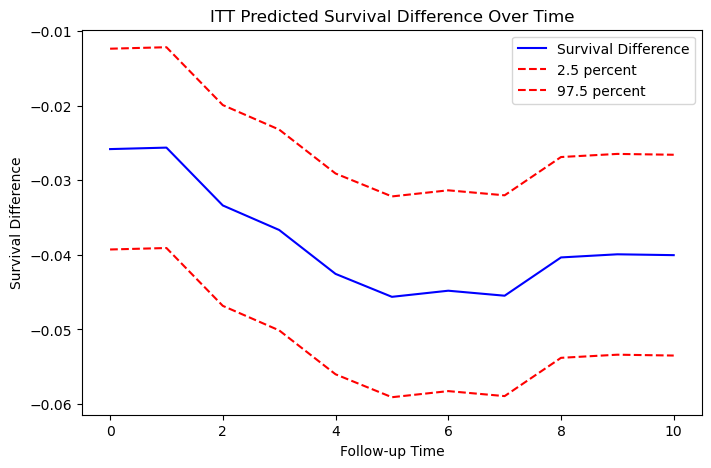

Survival predictions completed for Cluster 1.

=== Predicting Survival for Cluster 0 ===


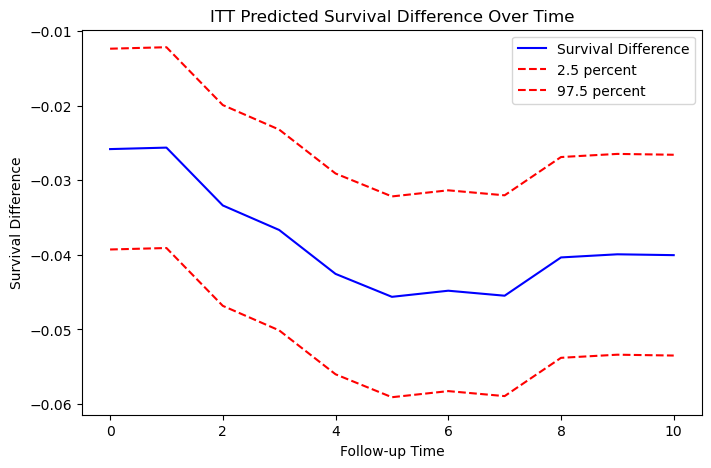

Survival predictions completed for Cluster 0.

=== Predicting Survival for Cluster 2 ===


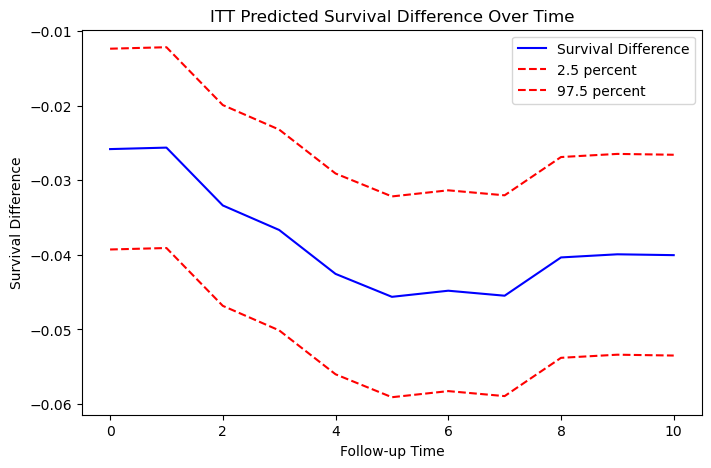

Survival predictions completed for Cluster 2.


In [47]:
# Step 12: Inference - Predict Survival Differences

# Define function to predict survival differences
def predict_survival(model, data, times=np.arange(0, 11)):
    data_control = data.copy()
    data_control["assigned_treatment"] = 0
    data_control["followup_time_sq"] = data_control["followup_time"] ** 2

    data_treated = data.copy()
    data_treated["assigned_treatment"] = 1
    data_treated["followup_time_sq"] = data_treated["followup_time"] ** 2

    preds_control = model.predict(data_control)
    preds_treated = model.predict(data_treated)

    survival_control = 1 - preds_control.groupby(data_control["followup_time"]).mean()
    survival_treated = 1 - preds_treated.groupby(data_treated["followup_time"]).mean()

    survival_diff = survival_treated.reindex(times) - survival_control.reindex(times)
    survival_diff = survival_diff.ffill().fillna(0)

    se_diff = np.std(survival_diff)
    ci_lower = survival_diff - 1.96 * se_diff
    ci_upper = survival_diff + 1.96 * se_diff

    plt.figure(figsize=(8, 5))
    plt.plot(times, survival_diff, "b-", label="Survival Difference")
    plt.plot(times, ci_lower, "r--", label="2.5 percent")
    plt.plot(times, ci_upper, "r--", label="97.5 percent")
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("ITT Predicted Survival Difference Over Time")
    plt.legend()
    plt.show()

    return {"followup_time": times, "survival_diff": survival_diff, "ci_lower": ci_lower, "ci_upper": ci_upper}

# Run inference for each cluster
for cluster in df["Cluster"].unique():
    cluster = str(cluster)

    print(f"\n=== Predicting Survival for Cluster {cluster} ===")

    if cluster in trial_itt_clusters:
        preds = predict_survival(trial_itt_clusters[cluster].outcome_model, trial_itt_clusters[cluster].loaded_data)
        print(f"Survival predictions completed for Cluster {cluster}.")
    else:
        print(f"Warning: Cluster {cluster} not found in trial_itt_clusters.")


## 13. Inference: Treatment Effect Estimation Per Cluster

Now that we have our fitted outcome models, we use them to estimate **survival probabilities** for both **treated** and **control groups** at different follow-up times.

Inference allows us to:
- **Estimate the predicted treatment effect** (e.g., survival difference over time).
- **Compute confidence intervals** to assess statistical significance.
- **Visualize survival differences** for each patient subgroup.

### **Clustering Adjustment**
Since different patient clusters may experience **different survival outcomes**, we **compute treatment effect estimates separately per cluster**. This ensures that:
- **Treatment effect heterogeneity** across clusters is captured.
- **Comparisons remain within similar patient groups**, reducing bias.
- We can detect **subgroup-specific survival benefits**.

We will now compute **predicted survival differences** separately for each cluster.



=== Plotting Survival Difference for Cluster 1 ===


<Figure size 800x500 with 0 Axes>

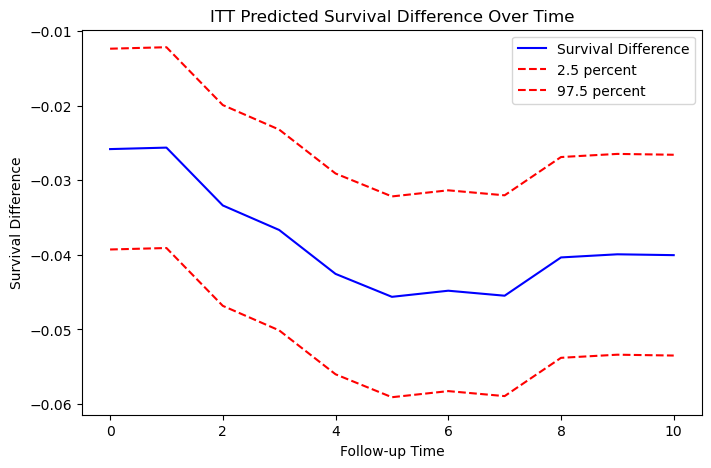


=== Plotting Survival Difference for Cluster 0 ===


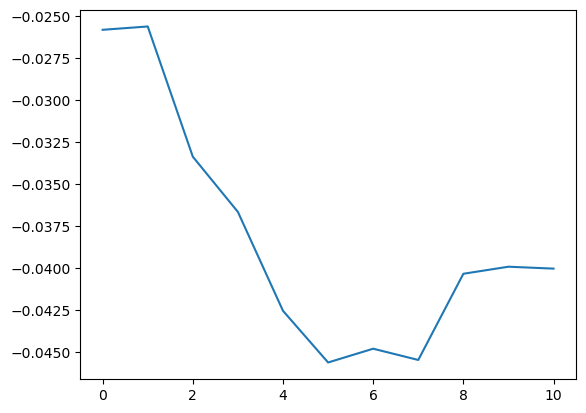

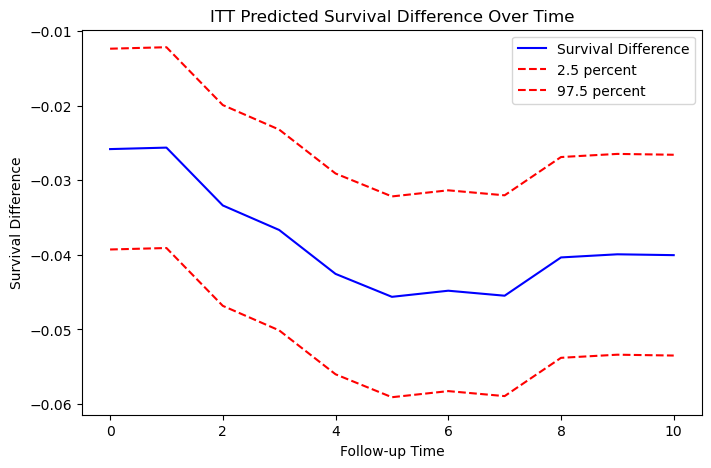


=== Plotting Survival Difference for Cluster 2 ===


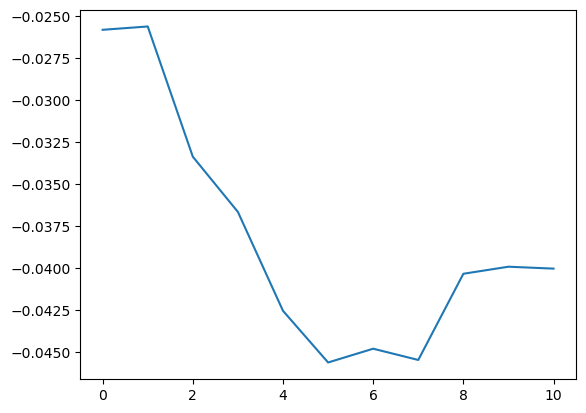

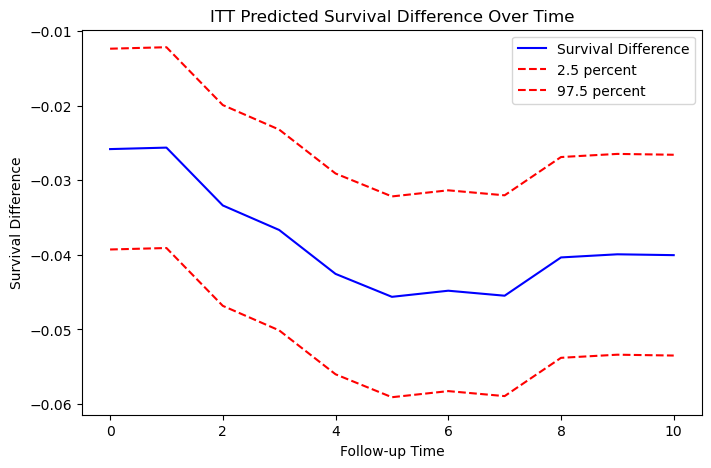

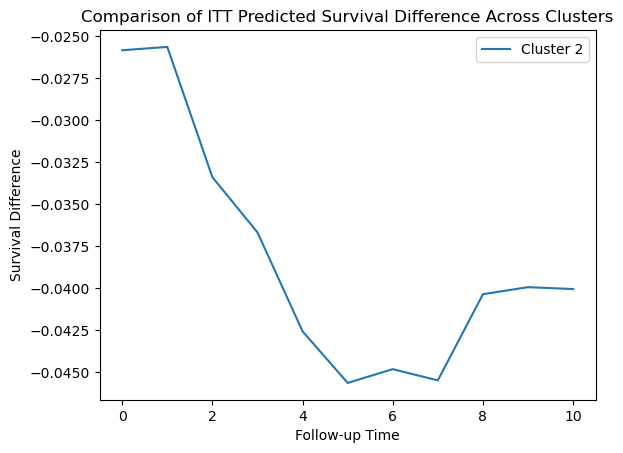

In [48]:
# Step 13: Compare Results Across Clusters

plt.figure(figsize=(8, 5))

for cluster in df["Cluster"].unique():
    cluster = str(cluster)

    print(f"\n=== Plotting Survival Difference for Cluster {cluster} ===")

    if cluster in trial_itt_clusters:
        preds = predict_survival(trial_itt_clusters[cluster].outcome_model, trial_itt_clusters[cluster].loaded_data)
        plt.plot(preds["followup_time"], preds["survival_diff"], label=f"Cluster {cluster}")
    else:
        print(f"Warning: Cluster {cluster} not found in trial_itt_clusters.")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Comparison of ITT Predicted Survival Difference Across Clusters")
plt.legend()
plt.show()


## Conclusion

By incorporating **K-Means clustering as a preprocessing step in Target Trial Emulation**, we enhance the credibility of treatment effect estimation in observational data. This approach ensures that comparisons are made **within similar patient groups**, reducing confounding and enabling a **more granular understanding** of treatment response heterogeneity.